<a href="https://colab.research.google.com/github/t2wain/colab/blob/master/Learn_MNIST_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import math

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical, plot_model
from keras.datasets import mnist
from keras import optimizers
from keras import metrics
from keras import losses
from keras import callbacks
import keras.backend as K

# **Inspecting data**

In [0]:
digits = datasets.load_digits()

In [0]:
print("data:", digits.data.shape, type(digits.data))
print("target:", digits.target.shape, type(digits.target))
print("target_names:", digits.target_names.shape, type(digits.target_names))
print("images:", digits.images.shape, type(digits.images))

data: (1797, 64) <class 'numpy.ndarray'>
target: (1797,) <class 'numpy.ndarray'>
target_names: (10,) <class 'numpy.ndarray'>
images: (1797, 8, 8) <class 'numpy.ndarray'>


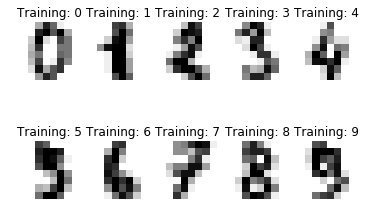

In [0]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# **Example 1**

### Utility methods

In [0]:
def data_gen(X, Y=None, batch_size=1, epochs=1):
  X_size, _ = X.shape

  for ep in range(epochs):
    for step in range(X_size // batch_size):
      offset = (step * batch_size) % X_size
      batch_x = X[offset:(offset + batch_size), :]
      batch_y = None if Y is None else Y[offset:(offset + batch_size)]
      yield (batch_x, batch_y)
    remainder = X_size % batch_size
    if remainder > 0:
      offset = X_size - remainder
      batch_x = X[offset:, :]
      batch_y = None if Y is None else Y[offset:]
      yield (batch_x, batch_y)

In [0]:
def build_dnn(num_features, num_labels, hiddens=[]):
  
  def loss(Y, y_prob):
    xentropy = -tf.reduce_sum(Y * tf.log(y_prob), reduction_indices=1)
    loss = tf.reduce_mean(xentropy, name='cost')
    return loss


  def loss_logit(Y, logit):
    xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=Y)
    loss = tf.reduce_mean(tf.reduce_sum(xentropy), name='cost')
    #loss = tf.reduce_sum(xentropy, name='cost')
    return loss


  num_sample = None
  with tf.name_scope('placeholders'):
    Xin = tf.placeholder(tf.float32, shape=[num_sample, num_features], name='Xin')
    Yin = tf.placeholder(tf.float32, shape=[num_sample, num_labels], name='Yin')
    rate = tf.placeholder(tf.float32, name='dropout_rate')
  
  X = Xin; W = None; layers = []; y_out = None
  # create nodes for hidden layers
  num_input = num_features
  num_hidden_layers = len(hiddens)

  for layer_num, num_node_output in enumerate(hiddens):
    layer_name = "hidden_layer_%d" % (layer_num+1)
    with tf.name_scope(layer_name):
      with tf.variable_scope(layer_name):
        W = tf.get_variable('W', 
          initializer=tf.truncated_normal([num_input, num_node_output], stddev=0.1))
        b = tf.get_variable('b', 
          initializer=tf.Variable(tf.constant(0.1,shape=[num_node_output])))
      fx = tf.add(tf.matmul(X, W), b) # linear regression
      y_out = tf.nn.relu6(fx) # activation funtion to introduce non-linearity
      # apply dropout to hidden layer to introduce regularization of W
      layer_drop = tf.nn.dropout(y_out, rate=rate, name='y_out')
      y_out = layer_drop
      # keeping track of each layer
      layers.append({"W": W, "b": b, "out": y_out, "W_val": None, "b_val": None})
      X = y_out # y become Xin to next layer
      num_input = num_node_output
  
  # create output layer
  num_input = num_features if W is None else num_input
  num_node_output = num_labels
  with tf.name_scope('output'):
    with tf.variable_scope('output'):
      W = tf.get_variable('W', 
        initializer=tf.truncated_normal([num_input, num_node_output], stddev=0.1))
      b = tf.get_variable('b', 
        initializer=tf.constant(0.1,shape=[num_node_output]))
    y_logit = tf.add(tf.matmul(X, W), b) # logistic regression, ln-odd
    # convert to probability, exp-logit, and normalize to interval between 0 and 1
    y_prob = tf.nn.softmax(y_logit, name='y_prob')
    layers.append({"W": W, "b": b, "out": y_prob, "W_val": None, "b_val": None})
    y_pred = tf.argmax(y_prob, 1, name='y_pred') # index of max probablity
    y_label = tf.argmax(Yin, 1, name='y_label') # index of one-hot label

  with tf.name_scope('optimize'):
    cost = loss_logit(Yin, y_logit)
    #cost = loss(Yin, y_prob)
    op = tf.train.AdamOptimizer()
    # minimize cost/loss
    train_op = op.minimize(cost)
  
  with tf.name_scope('metrics'):
    correct_prediction = tf.equal(y_pred, y_label)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"), name='accuracy')
  
  return {"x": Xin, "y": Yin, "dropout_rate": rate, "layers": layers, 
          "cost": cost, "accuracy": accuracy, "y_prob": y_prob, "y_pred": y_pred,
          "op": op, "train_op": train_op}

In [0]:
def build_classifier_estimator(num_features, num_labels, hiddens=[], msg_per_steps=0):
  is_saved = False
  
  g1 = tf.Graph()
  with g1.as_default() as graph:
    dnn = build_dnn(num_features, num_labels, hiddens)

  # placeholders, input to the training
  X = dnn["x"]
  Y = dnn["y"]
  rate = dnn["dropout_rate"]

  # optimizer
  op = dnn["op"]
  train_op = dnn["train_op"]

  # metrics
  cost = dnn["cost"]
  accuracy = dnn["accuracy"]
  y_pred = dnn["y_pred"]
  y_prob = dnn["y_prob"]
  

  def train(xsample, ysample,  batch_size=1, training_epochs=1, 
            learning_rate=0.001, dropout_rate=0, max_loss=0.01, limit_count=4):
    op.learning_rate = learning_rate
    loss_count = 0
    with tf.Session(graph=g1) as sess:
      _restoreVars(sess)
      step_iterator = enumerate(data_gen(xsample, ysample,  batch_size, training_epochs))
      for step, (batch_xs, batch_labels) in step_iterator:
        feed_dict = {X: batch_xs, Y: batch_labels, rate: dropout_rate}
        sess.run(train_op, feed_dict=feed_dict)

        # print training progress
        if msg_per_steps > 0 and step % msg_per_steps == 0:
          feed_dict = {X: batch_xs, Y: batch_labels, rate: 0}
          cost_val, accuracy_val = sess.run([cost, accuracy], feed_dict=feed_dict)
          print(
              "Iteration", str(step), 
              "\t| Loss =", str(cost_val), 
              "\t| Accuracy =", str(accuracy_val))
          
        # early training stop
        if math.isnan(cost_val) or loss_count > limit_count:
          break;
        elif cost_val < max_loss:
          loss_count += 1
          
      _saveVars(sess)

      
  def _restoreVars(sess):
    sess.run(tf.global_variables_initializer())
    if is_saved:
      for layer in dnn["layers"]:
        sess.run(layer["W"].assign(layer["W_val"]))
        sess.run(layer["b"].assign(layer["b_val"]))

    
  def _saveVars(sess):
    nonlocal is_saved
    is_saved = True
    for layer in dnn["layers"]:
      layer["W_val"] = sess.run(layer["W"])
      layer["b_val"] = sess.run(layer["b"])

      
  def evaluate(xsample, ysample, batch_size=1):
    if not is_saved:
      return "Error: Training has not been done."

    with tf.Session(graph=g1) as sess:
      _restoreVars(sess)
      cost_total = accuracy_total = step = 0
      for step, (batch_xs, batch_ys) in enumerate(data_gen(xsample, ysample,  batch_size)):
        feed_dict = {X: batch_xs, Y: batch_ys, rate: 0}
        cost_val, accuracy_val = sess.run([cost, accuracy], feed_dict=feed_dict)
        cost_total += cost_val
        accuracy_total += accuracy_val
      return (cost_val/(step+1), accuracy_total/(step+1))

    
  def predict(xdata, labels, batch_size=1):
    if not is_saved:
      return "Error: Training has not been done."
      
    with tf.Session(graph=g1) as sess:
      _restoreVars(sess)
      pred = []; prob = []
      for (batch_xs, _) in data_gen(xdata, batch_size=batch_size):
        feed_dict={X: batch_xs, rate: 0}
        yprob = sess.run(y_prob, feed_dict=feed_dict)
        ypred = np.argmax(yprob, axis=1)
        pred.extend(ypred)
        prob.extend(yprob.round(3))
        
      df = pd.DataFrame(prob, columns=labels)
      plabel = labels[pred]
      df["ypred"] = plabel
      return df

    
  return (train, evaluate, predict)

In [0]:
def one_hot(labels, ydata):
  y_target = np.expand_dims(ydata, axis=1)
  enc = OneHotEncoder(categories=[labels])
  enc.fit(y_target)
  return (labels, enc.transform(y_target).toarray())

### Configure Example

In [0]:
def get_tensors_ex():
  g1 = tf.Graph()
  with g1.as_default() as graph:
    dnn = build_dnn(3, 4, [2,2])
    t = {"x": graph.get_tensor_by_name('placeholders/Xin:0'), 
        "y": graph.get_tensor_by_name('placeholders/Yin:0'), 
        "dropout_rate": graph.get_tensor_by_name('placeholders/dropout_rate:0'), 
        "cost": graph.get_tensor_by_name('optimize/cost:0'), 
        "accuracy": graph.get_tensor_by_name('metrics/accuracy:0'), 
        "out": graph.get_tensor_by_name('output/y_pred:0')}
  return (dnn, t)


get_tensors_ex()

In [0]:
def get_data(nsample=None):
  ds = datasets.load_digits()
  
  # build dataframe
  df = pd.DataFrame(ds.data)
  df["ydata"] = ds.target
  
  # get subset of data
  if not nsample==None:
    df = df.sample(nsample)
    
  # normalization
  df.iloc[:,:-1] = df.iloc[:,:-1].apply((lambda x: (x - x.mean()) / x.std()), axis=1)
  
  # one-hot encoding the target
  y_labels, y_dummies = one_hot(ds.target_names, df["ydata"].to_numpy())
  dhot = pd.DataFrame(y_dummies, columns=y_labels)
    
  # split dataset into train and test
  x_train, x_test, y_train, y_test = train_test_split(
    df, dhot, test_size=0.3)

  return (x_train, x_test, y_train, y_test, ds)


In [0]:
def ex(nsample=None):
  batch_size = 128
  learning_rate = 0.0001
  hidden_layers = [256,256]
  
  (x_train_ds, x_test_ds, y_train_ds, y_test_ds, ds) = get_data(nsample)
  x_train = x_train_ds.iloc[:,:-1].to_numpy()
  x_test = x_test_ds.iloc[:,:-1].to_numpy()
  y_train = y_train_ds.to_numpy()
  y_test = y_test_ds.to_numpy()

  train_size, num_features = x_train.shape
  num_labels = ds.target_names.shape[0]
  
  # build classifier
  (_train, _evaluate, _predict) = build_classifier_estimator(
      num_features, num_labels, hidden_layers, 200)


  def train(epochs=300, max_loss=0.01):
    _train(x_train, y_train, batch_size, epochs, learning_rate, 0.45, max_loss, 4)


  def evaluate():
    (cost_val, accuracy_val) = _evaluate(x_train, y_train, batch_size)
    print("Train metric:")
    print({"accuracy": accuracy_val, "loss": cost_val})
    
    (cost_val, accuracy_val) = _evaluate(x_test, y_test, batch_size)
    print("Test metric:")
    print({"accuracy": accuracy_val, "loss": cost_val})


  def predict():
    df = _predict(x_test, ds.target_names, batch_size)
    df.index = x_test_ds.index
    ydata = ds.target_names[np.argmax(y_test, axis=1)]
    df["ydata"] = ydata
    df["max_prob"] = df.iloc[:, 0:10].apply(lambda x: x.max(), axis=1)
    return df
  
  def plot_image(df_pred, title):
    idx = df_pred.index.to_numpy()
    images_labels_pred = list(zip(ds.images[idx], ds.target[idx], df_pred["ypred"].to_numpy()))
    fig = plt.figure()
    fig.suptitle(title, fontsize=16)
    for index, (image, label, pred) in enumerate(images_labels_pred[:10]):
        plt.subplot(2, 5, index + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('P:%i, D:%i' % (pred, label))
    plt.show()


  return (train, evaluate, predict, plot_image)

### Training

In [0]:
(ex_train, ex_eval, ex_predict, plot_image) = ex()
ex_train(1000, 1)

Iteration 0 	| Loss = 273.51886 	| Accuracy = 0.21875
Iteration 200 	| Loss = 1.8662926 	| Accuracy = 1.0
Iteration 400 	| Loss = 0.60827065 	| Accuracy = 1.0


In [0]:
ex_eval()

Train metric:
{'accuracy': 1.0, 'loss': 0.0319621205329895}
Test metric:
{'accuracy': 0.984375, 'loss': 0.04577687084674835}


## Analyze Prediction

In [0]:
df = ex_predict()

In [0]:
print("Correct prediction:")
df_correct = df.loc[df["ypred"] == df["ydata"]].sort_values(["max_prob"], axis=0, ascending=True)
df_correct

Correct prediction:


,0,1,2,3,4,5,6,7,8,9,ypred,ydata,max_prob
1571,0.137,0.337,0.004,0.000,0.009,0.014,0.002,0.014,0.459,0.023,8,8,0.459
46,0.012,0.054,0.001,0.000,0.145,0.638,0.000,0.013,0.055,0.083,5,5,0.638
95,0.000,0.212,0.001,0.000,0.000,0.000,0.733,0.000,0.053,0.000,6,6,0.733
1602,0.000,0.013,0.004,0.744,0.000,0.009,0.000,0.000,0.203,0.026,3,3,0.744
1747,0.004,0.771,0.000,0.000,0.135,0.001,0.005,0.002,0.079,0.001,1,1,0.771
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,4,4,1.000
1759,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,9,9,1.000
112,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,7,7,1.000
1600,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,2,1.000


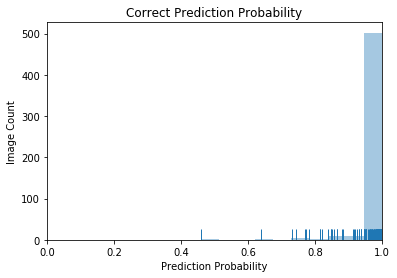

In [0]:
ax = sns.distplot(df_correct["max_prob"], kde=False, rug=True, bins=10)
ax.set_title("Correct Prediction Probability")
ax.set_ylabel("Image Count")
ax.set_xlabel("Prediction Probability")
ax.set_xlim(0,1)
plt.show()

In [0]:
print("Wrong prediction:")
df_err = df.loc[df["ypred"] != df["ydata"]].sort_values(["max_prob"], axis=0, ascending=False)
df_err

Wrong prediction:


,0,1,2,3,4,5,6,7,8,9,ypred,ydata,max_prob
5,0.000,0.001,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.993,9,5,0.993
1361,0.000,0.000,0.000,0.000,0.000,0.044,0.932,0.000,0.022,0.000,6,5,0.932
1149,0.001,0.026,0.013,0.000,0.063,0.017,0.015,0.823,0.036,0.008,7,8,0.823
1690,0.000,0.023,0.003,0.318,0.000,0.083,0.001,0.000,0.555,0.017,8,3,0.555
1658,0.000,0.012,0.001,0.554,0.000,0.001,0.000,0.000,0.423,0.009,3,9,0.554
1765,0.000,0.005,0.000,0.395,0.000,0.509,0.001,0.000,0.081,0.007,5,3,0.509
1727,0.000,0.001,0.459,0.184,0.000,0.000,0.000,0.003,0.352,0.000,2,3,0.459
492,0.134,0.015,0.000,0.000,0.009,0.005,0.395,0.000,0.442,0.000,8,6,0.442
922,0.001,0.002,0.162,0.431,0.001,0.015,0.001,0.338,0.048,0.001,3,7,0.431
792,0.224,0.002,0.000,0.000,0.373,0.116,0.275,0.000,0.010,0.001,4,6,0.373


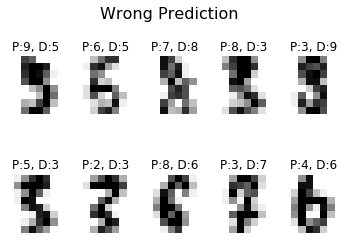

In [0]:
plot_image(df_err, "Wrong Prediction")

In [0]:
prob_threshold = 0.995
print("Correct prediction with high probability")
df_correct.loc[df["max_prob"] >= prob_threshold]

Correct prediction with high probability


,0,1,2,3,4,5,6,7,8,9,ypred,ydata,max_prob
1058,0.000,0.000,0.000,0.002,0.0,0.003,0.000,0.0,0.000,0.995,9,9,0.995
291,0.000,0.000,0.000,0.000,0.0,0.995,0.000,0.0,0.000,0.005,5,5,0.995
1126,0.000,0.995,0.000,0.000,0.0,0.000,0.000,0.0,0.004,0.000,1,1,0.995
1618,0.000,0.000,0.995,0.004,0.0,0.000,0.000,0.0,0.000,0.000,2,2,0.995
1768,0.995,0.000,0.000,0.000,0.0,0.000,0.005,0.0,0.000,0.000,0,0,0.995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,0.000,0.000,0.000,0.000,1.0,0.000,0.000,0.0,0.000,0.000,4,4,1.000
1759,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,1.000,9,9,1.000
112,0.000,0.000,0.000,0.000,0.0,0.000,0.000,1.0,0.000,0.000,7,7,1.000
1600,0.000,0.000,1.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,2,2,1.000


In [0]:
print("Wrong prediction despite high probability")
df_err.loc[df["max_prob"] >= prob_threshold]

Wrong prediction despite high probability


,0,1,2,3,4,5,6,7,8,9,ypred,ydata,max_prob


# **Example 2**

### Configure Example

In [0]:
def build_dnn_keras(num_features, num_labels, hiddens=[], dropout_rate=0.45, name="digits"):
  lname = "%s_model" % name
  model = Sequential(name=lname)

  is_hidden_layers = len(hiddens) > 0
  num_node = num_labels
  num_node = hiddens[0] if is_hidden_layers else num_labels
  lname = "1" if is_hidden_layers else "out"
  lname = "%s_l%s" % (name, lname)
  model.add(Dense(num_node, input_dim=num_features, name=lname))

  if (is_hidden_layers):
    lname = "%s_a1" % name
    model.add(Activation('relu', name=lname))
    lname = "%s_d1" % name
    model.add(Dropout(rate=dropout_rate, name=lname))
    for layer_num, hidden_node_num in enumerate(hiddens[1:]):
      lname = "%s_l%i" % (name, layer_num+2)
      model.add(Dense(hidden_node_num, name=lname))
      lname = "%s_a%i" % (name, layer_num+2)
      model.add(Activation('relu', name=lname))
      lname = "%s_d%i" % (name, layer_num+2)
      model.add(Dropout(rate=dropout_rate, name=lname))
    lname = "%s_out" % name
    model.add(Dense(num_labels, name=lname))

  lname = "%s_aout" % name
  model.add(Activation('softmax', name=lname))
  return model

In [0]:
def get_data_keras():
  # load mnist dataset
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  y_data = y_test

  # compute the number of labels
  num_labels = len(np.unique(y_train))

  # convert to one-hot vector
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  # image dimensions (assumed square)
  image_size = x_train.shape[1]
  input_size = image_size * image_size

  # resize and normalize
  x_train = np.reshape(x_train, [-1, input_size])
  x_train = x_train.astype('float32') / 255
  #x_train = np.apply_along_axis(lambda x: (x - x.mean() / x.std()), axis=1, arr=x_train) 
  x_test = np.reshape(x_test, [-1, input_size])
  x_test = x_test.astype('float32') / 255
  #x_test = np.apply_along_axis(lambda x: (x - x.mean() / x.std()), axis=1, arr=x_test)

  return (x_train, x_test, y_train, y_test, y_data)

In [0]:
def ex2():
  is_trained = False

  (x_train, x_test, y_train, y_test, y_data) = get_data_keras()
  input_size = x_train.shape[1]
  num_labels = y_train.shape[1]

  # network parameters
  batch_size = 128
  hidden_layers = [256, 256]
  dropout = 0.45
  learning_rate = 0.01

  # model is a 3-layer MLP with ReLU and dropout after each layer
  model = build_dnn_keras(input_size, num_labels, hidden_layers, dropout)
  model.summary()

  # loss function for one-hot vector
  # use of adam optimizer
  # accuracy is a good metric for classification tasks
  op = optimizers.Adam(lr=learning_rate)
  model.compile(
    loss=losses.categorical_crossentropy,
    optimizer=op,
    metrics=[metrics.categorical_accuracy])    # train the network


  def _reset_weights(model):
    K.get_session().close()
    K.set_session(tf.Session())
    K.get_session().run(tf.global_variables_initializer())


  def train(epochs=1, loss_delta=0.1):
    nonlocal is_trained
    if is_trained:
      _reset_weights(model)

 
    early_stopping_monitor = callbacks.EarlyStopping(
      monitor='loss',
      min_delta=loss_delta,
      patience=2,
      verbose=1,
      restore_best_weights=True)

    history = model.fit(x_train, y_train, 
      epochs=epochs, 
      batch_size=batch_size,
      callbacks=[early_stopping_monitor])
    
    is_trained = True
    return history


  def evaluate():
    # validate the model on test dataset to determine generalization
    print("Training metrics:")
    loss, accuracy = model.evaluate(x_train, y_train, batch_size=batch_size, verbose=0)
    print({"loss": loss, "accuracy": accuracy})
    print("Test metrics:")
    loss, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    print({"loss": loss, "accuracy": accuracy})


  def predict():
    #pred_class = model.predict_classes(x_test)
    pred_prob = model.predict(x_test)
    pred_class = np.argmax(pred_prob, axis=1)
    df = pd.DataFrame(pred_prob.round(3), columns=range(10))
    df["ypred"] = pred_class
    df["ydata"] = y_data
    df["prob"] = df.iloc[:, 0:10].apply(lambda x: x.max(), axis=1)
    return df


  return (train, evaluate, predict)

### Training

In [203]:
train, evaluate, predict = ex2()

Model: "digits_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits_l1 (Dense)            (None, 256)               200960    
_________________________________________________________________
digits_a1 (Activation)       (None, 256)               0         
_________________________________________________________________
digits_d1 (Dropout)          (None, 256)               0         
_________________________________________________________________
digits_l2 (Dense)            (None, 256)               65792     
_________________________________________________________________
digits_a2 (Activation)       (None, 256)               0         
_________________________________________________________________
digits_d2 (Dropout)          (None, 256)               0         
_________________________________________________________________
digits_out (Dense)           (None, 10)               

In [204]:
hist = train(20, 0.01)

Epoch 1/20
60000/60000 [==============================] - 7s 118us/step - loss: 0.4570 - categorical_accuracy: 0.8670
Epoch 2/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.3743 - categorical_accuracy: 0.9011
Epoch 3/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.3589 - categorical_accuracy: 0.9092
Epoch 4/20
60000/60000 [==============================] - 5s 78us/step - loss: 0.3513 - categorical_accuracy: 0.9140
Epoch 5/20
60000/60000 [==============================] - 5s 76us/step - loss: 0.3441 - categorical_accuracy: 0.9166
Epoch 6/20
60000/60000 [==============================] - 5s 76us/step - loss: 0.3531 - categorical_accuracy: 0.9196
Epoch 7/20
60000/60000 [==============================] - 5s 78us/step - loss: 0.3319 - categorical_accuracy: 0.9219
Epoch 8/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.3316 - categorical_accuracy: 0.9229
Epoch 9/20
60000/60000 [==============================] - 5s 77

In [205]:
evaluate()

Training metrics:
{'loss': 0.14508380025426545, 'accuracy': 0.9641166666666666}
Test metrics:
{'loss': 0.18203887531757354, 'accuracy': 0.957}


### Analyze Prediction

In [0]:
df = predict()

In [207]:
print("Correct prediction:")
df_correct = df.loc[df["ypred"] == df["ydata"]].sort_values(["prob"], axis=0, ascending=True)
df_correct

Correct prediction:


,0,1,2,3,4,5,6,7,8,9,ypred,ydata,prob
3225,0.055,0.069,0.110,0.071,0.113,0.080,0.049,0.160,0.144,0.148,7,7,0.160
7678,0.057,0.081,0.170,0.111,0.070,0.084,0.071,0.100,0.150,0.106,2,2,0.170
4874,0.110,0.037,0.097,0.048,0.135,0.073,0.120,0.064,0.147,0.170,9,9,0.170
4140,0.057,0.060,0.128,0.084,0.099,0.078,0.070,0.142,0.170,0.113,8,8,0.170
6625,0.067,0.064,0.104,0.066,0.120,0.087,0.075,0.114,0.182,0.122,8,8,0.182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,5,5,1.000
4066,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,2,1.000
4064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,7,7,1.000
4061,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,7,7,1.000


In [208]:
print("Correct prediction probability spread:")
grp_correct = df_correct.groupby(pd.cut(df_correct.prob, np.linspace(0, 1, 21)))
grp_correct.count().ypred

Correct prediction probability spread:


prob
(0.0, 0.05]       0
(0.05, 0.1]       0
(0.1, 0.15]       0
(0.15, 0.2]      12
(0.2, 0.25]      24
(0.25, 0.3]      33
(0.3, 0.35]      30
(0.35, 0.4]      32
(0.4, 0.45]      29
(0.45, 0.5]      46
(0.5, 0.55]      48
(0.55, 0.6]      59
(0.6, 0.65]      55
(0.65, 0.7]      65
(0.7, 0.75]      63
(0.75, 0.8]      81
(0.8, 0.85]      85
(0.85, 0.9]     137
(0.9, 0.95]     226
(0.95, 1.0]    8545
Name: ypred, dtype: int64

In [209]:
print("Wrong prediction:")
df_err = df.loc[df["ypred"] != df["ydata"]].sort_values(["prob"], axis=0, ascending=False)
df_err

Wrong prediction:


,0,1,2,3,4,5,6,7,8,9,ypred,ydata,prob
2654,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,6,1.000
1260,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,7,1.000
4211,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,5,6,1.000
965,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,6,1.000
1014,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,5,6,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6568,0.066,0.077,0.116,0.067,0.169,0.068,0.061,0.116,0.148,0.112,4,9,0.169
1444,0.106,0.036,0.103,0.023,0.151,0.042,0.127,0.165,0.097,0.149,7,6,0.165
1039,0.053,0.075,0.111,0.078,0.094,0.094,0.034,0.147,0.164,0.150,8,7,0.164
2919,0.041,0.050,0.092,0.067,0.162,0.156,0.064,0.080,0.137,0.151,4,5,0.162


In [210]:
print("Wrong prediction probability spread:")
grp_err = df_err.groupby(pd.cut(df_err.prob, np.linspace(0, 1, 21)))
grp_err.count().ypred

Wrong prediction probability spread:


prob
(0.0, 0.05]     0
(0.05, 0.1]     0
(0.1, 0.15]     0
(0.15, 0.2]    42
(0.2, 0.25]    42
(0.25, 0.3]    35
(0.3, 0.35]    30
(0.35, 0.4]    28
(0.4, 0.45]    19
(0.45, 0.5]    23
(0.5, 0.55]    21
(0.55, 0.6]    31
(0.6, 0.65]    14
(0.65, 0.7]    17
(0.7, 0.75]     8
(0.75, 0.8]    15
(0.8, 0.85]    14
(0.85, 0.9]    15
(0.9, 0.95]    16
(0.95, 1.0]    60
Name: ypred, dtype: int64